# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [2]:
# Add any additional import statements you need here
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

In [3]:
data_location = r"C:\Users\keevi\OneDrive\Documents\SDU\ADS-509\Week6"

# Assuming M1 Results folder is where twitter and lyrics folders are located
twitter_folder = "M1 Results\\twitter\\"
lyrics_folder = "M1 Results\\lyrics\\"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [4]:
# Read in the lyrics data

import os

# Set up the path variables
data_location = r"C:\Users\keevi\OneDrive\Documents\SDU\ADS-509\Week6"
lyrics_folder = "M1 Results\\lyrics"

# List all files in the lyrics folder that end with '.txt'
lyrics_files = [file for file in os.listdir(os.path.join(data_location, lyrics_folder))
                if file.endswith('.txt')]

# Define a function to read and process each lyrics file
def read_lyrics(file_path):
    print(f"Reading file: {file_path}")
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            lyrics_text = file.read()
            # Process lyrics_text as needed
            print(lyrics_text)  # Example: Printing the lyrics text
    except UnicodeDecodeError:
        print(f"Unable to read {file_path} as UTF-8 encoded text.")

# Read each lyrics file
for file_name in lyrics_files:
    file_path = os.path.join(data_location, lyrics_folder, file_name)
    read_lyrics(file_path)


In [5]:
# Read in the twitter data

import os

# Set up the path variables
data_location = r"C:\Users\keevi\OneDrive\Documents\SDU\ADS-509\Week6"
twitter_folder = "M1 Results\\twitter"

# List all files in the twitter folder
twitter_files = os.listdir(os.path.join(data_location, twitter_folder))

# Define a function to read and print the first few lines of each file
def print_first_few_lines(file_path, num_lines=10):
    print(f"Reading file: {file_path}")
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for i, line in enumerate(file):
                if i < num_lines:
                    print(line.strip())  # Print each line (remove trailing newline)
                else:
                    break
    except UnicodeDecodeError:
        print(f"Unable to read {file_path} as UTF-8 encoded text.")
    except IsADirectoryError:
        print(f"{file_path} is a directory, not a file.")

# Read each file
for file_name in twitter_files:
    file_path = os.path.join(data_location, twitter_folder, file_name)
    print_first_few_lines(file_path)


Reading file: C:\Users\keevi\OneDrive\Documents\SDU\ADS-509\Week6\M1 Results\twitter\.DS_Store
Unable to read C:\Users\keevi\OneDrive\Documents\SDU\ADS-509\Week6\M1 Results\twitter\.DS_Store as UTF-8 encoded text.
Reading file: C:\Users\keevi\OneDrive\Documents\SDU\ADS-509\Week6\M1 Results\twitter\cher_followers.txt
id
35152213
742153090850164742
1496463006451974150
3366479914
83915043
1502787622376075264
1386454132022824962
1200870825953550336
1492913469166743554
Reading file: C:\Users\keevi\OneDrive\Documents\SDU\ADS-509\Week6\M1 Results\twitter\cher_followers_data.txt
screen_name	name	id	location	followers_count	friends_count	description
hsmcnp	Country Girl	35152213		1302	1014
horrormomy	Jeny	742153090850164742	Earth	81	514	𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜
anju79990584	anju	1496463006451974150		13	140	163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡
gallionjenna	J	3366479914		752	556	csu
bcscomm	bcscomm	83915043	Washington, DC	888	2891	Writer @Washinformer @SpelmanCollege alumna #D

In [39]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.
import os
import re
from collections import Counter

# Define absolute paths to your data files
data_location = r"C:\Users\keevi\OneDrive\Documents\SDU\ADS-509\Week6"
positive_words_file = os.path.join(data_location, "positive-words.txt")
negative_words_file = os.path.join(data_location, "negative-words.txt")
tidy_text_file = os.path.join(data_location, "tidytext_sentiments.txt")

# Function to read words from a file and assign sentiment score
def read_sentiment_words(file_path, sentiment_score):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            words = file.read().splitlines()
        
        word_sentiments = Counter()
        for line in words:
            tokens = re.findall(r'\b\w+\b', line.lower())  # Tokenize and normalize
            for token in tokens:
                word_sentiments[token] += sentiment_score
        
        top_words = dict(word_sentiments.most_common(30))
        return top_words
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return {}
    except IOError:
        print(f"Error reading file: {file_path}")
        return {}

# Read positive and negative words
positive_words = read_sentiment_words(positive_words_file, 1)
negative_words = read_sentiment_words(negative_words_file, -1)

# Read tidytext sentiments (if applicable)
tidytext_sentiments = read_sentiment_words(tidy_text_file, 0)  # Assuming tidytext file has a different scoring system

# Example usage:
print("Top 30 Positive Words:")
print(positive_words)
print("\nTop 30 Negative Words:")
print(negative_words)
print("\nTop 30 Tidytext Sentiments:")
print(tidytext_sentiments)

Top 30 Positive Words:
{'well': 21, 'the': 10, 'and': 8, 'free': 8, 'of': 7, 'opinion': 5, 'in': 5, 'self': 5, 'positive': 4, 'a': 4, 'words': 4, 'best': 4, 'low': 4, 'this': 3, 'list': 3, 'sentiment': 3, 'all': 3, 'bing': 3, 'liu': 3, 'on': 3, 'known': 3, 'better': 3, 'cost': 3, 'fast': 3, 'first': 3, 'friendly': 3, 'top': 3, 'file': 2, 'or': 2, 'papers': 2}

Top 30 Negative Words:
{'lexicon': -1, 'contains': -1, 'can': -1, 'all': -1, 'be': -1, 'downloaded': -1, 'from': -1, 'http': -1, 'cs': -1, 'uic': -1, 'edu': -1, 'liub': -1, 'fbs': -1, 'html': -1, 'if': -1, 'use': -1, 'please': -1, 'cite': -1, 'following': -1, 'summarizing': -1, 'customer': -1, 'reviews': -1, 'acm': -1, 'sigkdd': -1, 'knowledge': -1, 'discovery': -1, 'data': -1, 'kdd': -1, 'aug': -1, '22': -1}

Top 30 Tidytext Sentiments:
{'word': 0, 'sentiment': 0, 'lexicon': 0, 'abandon': 0, 'negative': 0, 'nrc': 0, 'abandoned': 0, 'abandonment': 0, 'abba': 0, 'positive': 0, 'abduction': 0, 'aberrant': 0, 'aberration': 0, 'abhor

### Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository.

After you have calculated these sentiments, answer the questions at the end of this section.


### Analysis of Cher Songs

In [7]:
import os

# Define absolute path to your data files directory
data_location = r"C:\Users\keevi\OneDrive\Documents\SDU\ADS-509\Week6"

# Define folders for lyrics and twitter data
lyrics_folder = os.path.join(data_location, "M1 Results", "lyrics")

# Define lexicon file names
positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

# Function to read words from a file and assign sentiment score
def read_sentiment_words(file_path, sentiment_score):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            words = file.read().splitlines()
        word_sentiments = {word.strip(): sentiment_score for word in words}
        return word_sentiments
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return {}

# Read positive and negative words with sentiment scores
positive_words = read_sentiment_words(os.path.join(data_location, positive_words_file), 1)
negative_words = read_sentiment_words(os.path.join(data_location, negative_words_file), -1)
tidytext_sentiments = read_sentiment_words(os.path.join(data_location, tidy_text_file), 0)

# Combine lexicons into a single dictionary
sentiment_lexicon = {**positive_words, **negative_words, **tidytext_sentiments}

# Function to score sentiment of lyrics
def score_lyrics_sentiment(file_path, sentiment_lexicon):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            lyrics_text = file.read()

        # Tokenize lyrics into words (split by whitespace for simplicity)
        words = lyrics_text.split()

        # Initialize sentiment score
        sentiment_score = 0

        # Calculate sentiment score based on lexicon
        for word in words:
            if word.lower() in sentiment_lexicon:
                sentiment_score += sentiment_lexicon[word.lower()]

        return sentiment_score

    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None
    except UnicodeDecodeError:
        print(f"Error: Unable to read '{file_path}' as UTF-8 encoded text.")
        return None

# Function to process lyrics folder and return top 3 and bottom 3 song titles with sentiment scores
def get_top_and_bottom_three_song_titles_with_scores(folder_path, artist_name):
    song_sentiments = []
    try:
        files = [file for file in os.listdir(folder_path) if file.endswith('.txt')]
        for file_name in files:
            file_path = os.path.join(folder_path, file_name)
            sentiment_score = score_lyrics_sentiment(file_path, sentiment_lexicon)
            if sentiment_score is not None:
                song_sentiments.append((file_name, sentiment_score))
        
        # Sort songs by sentiment score in descending order
        song_sentiments.sort(key=lambda x: x[1], reverse=True)
        
        # Get top 3 songs with highest sentiment scores
        top_three_songs = song_sentiments[:3]
        
        # Get bottom 3 songs with lowest sentiment scores
        bottom_three_songs = song_sentiments[-3:]
        
        return top_three_songs, bottom_three_songs

    except FileNotFoundError:
        print(f"Error: Directory '{folder_path}' not found.")
        return [], []
    except Exception as e:
        print(f"Error: {e}")
        return [], []

# Process lyrics for Cher
cher_folder = os.path.join(lyrics_folder, "cher")
print("Processing Cher's songs:")
top_three_cher_songs, bottom_three_cher_songs = get_top_and_bottom_three_song_titles_with_scores(cher_folder, "Cher")

# Print top 3 song titles with highest sentiment scores and their sentiment scores
print("\nTop 3 Songs with Highest Sentiment for Cher:")
for song_title, sentiment_score in top_three_cher_songs:
    print(f"Song Title: {song_title}")
    print(f"Sentiment Score: {sentiment_score}")
    print("----------------------")

# Print bottom 3 song titles with lowest sentiment scores and their sentiment scores
print("\nBottom 3 Songs with Lowest Sentiment for Cher:")
for song_title, sentiment_score in bottom_three_cher_songs:
    print(f"Song Title: {song_title}")
    print(f"Sentiment Score: {sentiment_score}")
    print("----------------------")

Processing Cher's songs:

Top 3 Songs with Highest Sentiment for Cher:
Song Title: cher_loveandunderstanding.txt
Sentiment Score: 41
----------------------
Song Title: cher_perfection.txt
Sentiment Score: 41
----------------------
Song Title: cher_mylove.txt
Sentiment Score: 34
----------------------

Bottom 3 Songs with Lowest Sentiment for Cher:
Song Title: cher_dressedtokill.txt
Sentiment Score: -16
----------------------
Song Title: cher_outrageous.txt
Sentiment Score: -20
----------------------
Song Title: cher_iwalkonguildedsplinters.txt
Sentiment Score: -24
----------------------


In [8]:
# Define absolute path to your data files directory
data_location = r"C:\Users\keevi\OneDrive\Documents\SDU\ADS-509\Week6"

# Define folders for lyrics and twitter data
lyrics_folder = os.path.join(data_location, "M1 Results", "lyrics")

# Define lexicon file names
positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

# Function to read words from a file and assign sentiment score
def read_sentiment_words(file_path, sentiment_score):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            words = file.read().splitlines()
        word_sentiments = {word.strip(): sentiment_score for word in words}
        return word_sentiments
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return {}

# Read positive and negative words with sentiment scores
positive_words = read_sentiment_words(os.path.join(data_location, positive_words_file), 1)
negative_words = read_sentiment_words(os.path.join(data_location, negative_words_file), -1)
tidytext_sentiments = read_sentiment_words(os.path.join(data_location, tidy_text_file), 0)

# Combine lexicons into a single dictionary
sentiment_lexicon = {**positive_words, **negative_words, **tidytext_sentiments}

# Function to score sentiment of lyrics
def score_lyrics_sentiment(file_path, sentiment_lexicon):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            lyrics_text = file.read()

        # Tokenize lyrics into words (split by whitespace for simplicity)
        words = lyrics_text.split()

        # Initialize sentiment score
        sentiment_score = 0

        # Calculate sentiment score based on lexicon
        for word in words:
            if word.lower() in sentiment_lexicon:
                sentiment_score += sentiment_lexicon[word.lower()]

        return sentiment_score, lyrics_text

    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None, None
    except UnicodeDecodeError:
        print(f"Error: Unable to read '{file_path}' as UTF-8 encoded text.")
        return None, None

# Function to process lyrics folder and return songs with highest and lowest sentiment scores
def get_highest_and_lowest_sentiment_songs(folder_path, artist_name):
    song_sentiments = []
    try:
        files = [file for file in os.listdir(folder_path) if file.endswith('.txt')]
        for file_name in files:
            file_path = os.path.join(folder_path, file_name)
            sentiment_score, lyrics_text = score_lyrics_sentiment(file_path, sentiment_lexicon)
            if sentiment_score is not None:
                song_sentiments.append((file_name, sentiment_score, lyrics_text))
        
        # Sort songs by sentiment score in descending order
        song_sentiments.sort(key=lambda x: x[1], reverse=True)
        
        # Get top 3 songs with highest sentiment scores
        top_three_songs = song_sentiments[:3]
        
        # Get top 3 songs with lowest sentiment scores
        bottom_three_songs = song_sentiments[-3:]
        
        return top_three_songs, bottom_three_songs

    except FileNotFoundError:
        print(f"Error: Directory '{folder_path}' not found.")
        return [], []
    except Exception as e:
        print(f"Error: {e}")
        return [], []

# Process lyrics for Cher
cher_folder = os.path.join(lyrics_folder, "cher")
print("Processing Cher's songs:")
top_three_cher_songs, bottom_three_cher_songs = get_highest_and_lowest_sentiment_songs(cher_folder, "Cher")

# Print top 3 highest sentiment score songs and their lyrics
print("\nTop 3 Songs with Highest Sentiment Scores for Cher:")
for i, (song_title, sentiment_score, lyrics_text) in enumerate(top_three_cher_songs, 1):
    print(f"{i}. Song Title: {song_title}")
    print(f"   Sentiment Score: {sentiment_score}")
    print(f"   ----------------- LYRICS -----------------")
    print(lyrics_text)
    print("----------------------")

# Print top 3 lowest sentiment score songs and their lyrics
print("\nTop 3 Songs with Lowest Sentiment Scores for Cher:")
for i, (song_title, sentiment_score, lyrics_text) in enumerate(bottom_three_cher_songs, 1):
    print(f"{i}. Song Title: {song_title}")
    print(f"   Sentiment Score: {sentiment_score}")
    print(f"   ----------------- LYRICS -----------------")
    print(lyrics_text)
    print("----------------------")


Processing Cher's songs:

Top 3 Songs with Highest Sentiment Scores for Cher:
1. Song Title: cher_loveandunderstanding.txt
   Sentiment Score: 41
   ----------------- LYRICS -----------------
"Love And Understanding"



Here, here in this world
Where do we go? Where can we turn?
When we need some love
It seems that love just can't be found
Where, where do we stand?
When love's supply don't meet love's demand

We got enough stars to light the sky at night
Enough sun to make to make the whole world bright
We got more than enough
But there's one thing there's just not enough of

Not enough love and understanding
We could use some love to ease these troubled times
Not enough love and understanding
Why, oh why?

Spend all of our time
Building buildings up to the sky
Reaching everywhere
But where we need to reach the most
Hearts never can win
Oh, in this race, this race that we're in

We've got enough cars to drive around the world
Enough planes to take us anywhere
We got more than enough
Bu

### Analysis of Robyn Songs

In [12]:
import os

# Define absolute path to your data files directory
data_location = r"C:\Users\keevi\OneDrive\Documents\SDU\ADS-509\Week6"

# Define folders for lyrics and twitter data
lyrics_folder = os.path.join(data_location, "M1 Results", "lyrics")

# Define lexicon file names
positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

# Function to read words from a file and assign sentiment score
def read_sentiment_words(file_path, sentiment_score):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            words = file.read().splitlines()
        word_sentiments = {word.strip(): sentiment_score for word in words}
        return word_sentiments
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return {}

# Read positive and negative words with sentiment scores
positive_words = read_sentiment_words(os.path.join(data_location, positive_words_file), 1)
negative_words = read_sentiment_words(os.path.join(data_location, negative_words_file), -1)
tidytext_sentiments = read_sentiment_words(os.path.join(data_location, tidy_text_file), 0)

# Combine lexicons into a single dictionary
sentiment_lexicon = {**positive_words, **negative_words, **tidytext_sentiments}

# Function to score sentiment of lyrics
def score_lyrics_sentiment(file_path, sentiment_lexicon):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            lyrics_text = file.read()

        # Tokenize lyrics into words (split by whitespace for simplicity)
        words = lyrics_text.split()

        # Initialize sentiment score
        sentiment_score = 0

        # Calculate sentiment score based on lexicon
        for word in words:
            if word.lower() in sentiment_lexicon:
                sentiment_score += sentiment_lexicon[word.lower()]

        return sentiment_score

    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None
    except UnicodeDecodeError:
        print(f"Error: Unable to read '{file_path}' as UTF-8 encoded text.")
        return None

# Function to process lyrics folder and return top 3 and bottom 3 song titles with sentiment scores
def get_top_and_bottom_three_song_titles_with_scores(folder_path, artist_name):
    song_sentiments = []
    try:
        files = [file for file in os.listdir(folder_path) if file.endswith('.txt')]
        for file_name in files:
            file_path = os.path.join(folder_path, file_name)
            sentiment_score = score_lyrics_sentiment(file_path, sentiment_lexicon)
            if sentiment_score is not None:
                song_sentiments.append((file_name, sentiment_score))
        
        # Sort songs by sentiment score in descending order
        song_sentiments.sort(key=lambda x: x[1], reverse=True)
        
        # Get top 3 songs with highest sentiment scores
        top_three_songs = song_sentiments[:3]
        
        # Get bottom 3 songs with lowest sentiment scores
        bottom_three_songs = song_sentiments[-3:]
        
        return top_three_songs, bottom_three_songs

    except FileNotFoundError:
        print(f"Error: Directory '{folder_path}' not found.")
        return [], []
    except Exception as e:
        print(f"Error: {e}")
        return [], []

# Process lyrics for Robyn
cher_folder = os.path.join(lyrics_folder, "robyn")
print("Processing Robyn's songs:")
top_three_robyn_songs, bottom_three_robyn_songs = get_top_and_bottom_three_song_titles_with_scores(robyn_folder, "Robyn")

# Print top 3 song titles with highest sentiment scores and their sentiment scores
print("\nTop 3 Songs with Highest Sentiment for Robyn:")
for song_title, sentiment_score in top_three_robyn_songs:
    print(f"Song Title: {song_title}")
    print(f"Sentiment Score: {sentiment_score}")
    print("----------------------")

# Print bottom 3 song titles with lowest sentiment scores and their sentiment scores
print("\nBottom 3 Songs with Lowest Sentiment for Robyn:")
for song_title, sentiment_score in bottom_three_robyn_songs:
    print(f"Song Title: {song_title}")
    print(f"Sentiment Score: {sentiment_score}")
    print("----------------------")

Processing Robyn's songs:

Top 3 Songs with Highest Sentiment for Robyn:
Song Title: robyn_loveisfree.txt
Sentiment Score: 91
----------------------
Song Title: robyn_indestructible.txt
Sentiment Score: 26
----------------------
Song Title: robyn_ushouldknowbetter.txt
Sentiment Score: 25
----------------------

Bottom 3 Songs with Lowest Sentiment for Robyn:
Song Title: robyn_criminalintent.txt
Sentiment Score: -54
----------------------
Song Title: robyn_dontfuckingtellmewhattodo.txt
Sentiment Score: -77
----------------------
Song Title: robyn_dontfuckingtellmewhattodo114520.txt
Sentiment Score: -77
----------------------


In [10]:
import os

# Define absolute path to your data files directory
data_location = r"C:\Users\keevi\OneDrive\Documents\SDU\ADS-509\Week6"

# Define folders for lyrics and twitter data
lyrics_folder = os.path.join(data_location, "M1 Results", "lyrics")

# Define lexicon file names
positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

# Function to read words from a file and assign sentiment score
def read_sentiment_words(file_path, sentiment_score):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            words = file.read().splitlines()
        word_sentiments = {word.strip(): sentiment_score for word in words}
        return word_sentiments
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return {}

# Read positive and negative words with sentiment scores
positive_words = read_sentiment_words(os.path.join(data_location, positive_words_file), 1)
negative_words = read_sentiment_words(os.path.join(data_location, negative_words_file), -1)
tidytext_sentiments = read_sentiment_words(os.path.join(data_location, tidy_text_file), 0)

# Combine lexicons into a single dictionary
sentiment_lexicon = {**positive_words, **negative_words, **tidytext_sentiments}

# Function to score sentiment of lyrics
def score_lyrics_sentiment(file_path, sentiment_lexicon):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            lyrics_text = file.read()

        # Tokenize lyrics into words (split by whitespace for simplicity)
        words = lyrics_text.split()

        # Initialize sentiment score
        sentiment_score = 0

        # Calculate sentiment score based on lexicon
        for word in words:
            if word.lower() in sentiment_lexicon:
                sentiment_score += sentiment_lexicon[word.lower()]

        return sentiment_score, lyrics_text

    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None, None
    except UnicodeDecodeError:
        print(f"Error: Unable to read '{file_path}' as UTF-8 encoded text.")
        return None, None

# Function to process lyrics folder and return songs with highest and lowest sentiment scores
def get_highest_and_lowest_sentiment_songs(folder_path, artist_name):
    song_sentiments = []
    try:
        files = [file for file in os.listdir(folder_path) if file.endswith('.txt')]
        for file_name in files:
            file_path = os.path.join(folder_path, file_name)
            sentiment_score, lyrics_text = score_lyrics_sentiment(file_path, sentiment_lexicon)
            if sentiment_score is not None:
                song_sentiments.append((file_name, sentiment_score, lyrics_text))
        
        # Sort songs by sentiment score in descending order
        song_sentiments.sort(key=lambda x: x[1], reverse=True)
        
        # Get top 3 songs with highest sentiment scores
        top_three_songs = song_sentiments[:3]
        
        # Get top 3 songs with lowest sentiment scores
        bottom_three_songs = song_sentiments[-3:]
        
        return top_three_songs, bottom_three_songs

    except FileNotFoundError:
        print(f"Error: Directory '{folder_path}' not found.")
        return [], []
    except Exception as e:
        print(f"Error: {e}")
        return [], []

# Process lyrics for Robyn
robyn_folder = os.path.join(lyrics_folder, "robyn")
print("Processing Robyn's songs:")
top_three_robyn_songs, bottom_three_robyn_songs = get_highest_and_lowest_sentiment_songs(robyn_folder, "Robyn")

# Print top 3 highest sentiment score songs and their lyrics
print("\nTop 3 Songs with Highest Sentiment Scores for Robyn:")
for i, (song_title, sentiment_score, lyrics_text) in enumerate(top_three_robyn_songs, 1):
    print(f"{i}. Song Title: {song_title}")
    print(f"   Sentiment Score: {sentiment_score}")
    print(f"   ----------------- LYRICS -----------------")
    print(lyrics_text)
    print("----------------------")

# Print top 3 lowest sentiment score songs and their lyrics
print("\nTop 3 Songs with Lowest Sentiment Scores for Robyn:")
for i, (song_title, sentiment_score, lyrics_text) in enumerate(bottom_three_robyn_songs, 1):
    print(f"{i}. Song Title: {song_title}")
    print(f"   Sentiment Score: {sentiment_score}")
    print(f"   ----------------- LYRICS -----------------")
    print(lyrics_text)
    print("----------------------")


Processing Robyn's songs:

Top 3 Songs with Highest Sentiment Scores for Robyn:
1. Song Title: robyn_loveisfree.txt
   Sentiment Score: 91
   ----------------- LYRICS -----------------
"Love Is Free"



Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Chica boom chica boom chica boom
Chica boom chica boom chica boom
Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you ca

In [11]:
import os

# Define absolute path to your data files directory
data_location = r"C:\Users\keevi\OneDrive\Documents\SDU\ADS-509\Week6"

# Define folders for lyrics and twitter data
lyrics_folder = os.path.join(data_location, "M1 Results", "lyrics")

# Define lexicon file names
positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

# Function to read words from a file and assign sentiment score
def read_sentiment_words(file_path, sentiment_score):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            words = file.read().splitlines()
        word_sentiments = {word.strip(): sentiment_score for word in words}
        return word_sentiments
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return {}

# Read positive and negative words with sentiment scores
positive_words = read_sentiment_words(os.path.join(data_location, positive_words_file), 1)
negative_words = read_sentiment_words(os.path.join(data_location, negative_words_file), -1)
tidytext_sentiments = read_sentiment_words(os.path.join(data_location, tidy_text_file), 0)

# Combine lexicons into a single dictionary
sentiment_lexicon = {**positive_words, **negative_words, **tidytext_sentiments}

# Function to score sentiment of lyrics
def score_lyrics_sentiment(file_path, sentiment_lexicon):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            lyrics_text = file.read()

        # Tokenize lyrics into words (split by whitespace for simplicity)
        words = lyrics_text.split()

        # Initialize sentiment score
        sentiment_score = 0

        # Calculate sentiment score based on lexicon
        for word in words:
            if word.lower() in sentiment_lexicon:
                sentiment_score += sentiment_lexicon[word.lower()]

        return sentiment_score, lyrics_text

    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None, None
    except UnicodeDecodeError:
        print(f"Error: Unable to read '{file_path}' as UTF-8 encoded text.")
        return None, None

# Function to process lyrics folder and return songs with highest and lowest sentiment scores
def get_highest_and_lowest_sentiment_songs(folder_path, artist_name):
    song_sentiments = []
    try:
        files = [file for file in os.listdir(folder_path) if file.endswith('.txt')]
        for file_name in files:
            file_path = os.path.join(folder_path, file_name)
            sentiment_score, lyrics_text = score_lyrics_sentiment(file_path, sentiment_lexicon)
            if sentiment_score is not None:
                song_sentiments.append((file_name, sentiment_score, lyrics_text))
        
        # Sort songs by sentiment score in descending order
        song_sentiments.sort(key=lambda x: x[1], reverse=True)
        
        # Get top 3 songs with highest sentiment scores
        top_three_songs = song_sentiments[:3]
        
        # Get top 3 songs with lowest sentiment scores
        bottom_three_songs = song_sentiments[-3:]
        
        return top_three_songs, bottom_three_songs

    except FileNotFoundError:
        print(f"Error: Directory '{folder_path}' not found.")
        return [], []
    except Exception as e:
        print(f"Error: {e}")
        return [], []

# Process lyrics for Robyn
robyn_folder = os.path.join(lyrics_folder, "robyn")
print("Processing Robyn's songs:")
top_three_robyn_songs, bottom_three_robyn_songs = get_highest_and_lowest_sentiment_songs(robyn_folder, "Robyn")

# Print top 3 highest sentiment score songs and their lyrics
print("\nTop 3 Songs with Highest Sentiment Scores for Robyn:")
for i, (song_title, sentiment_score, lyrics_text) in enumerate(top_three_robyn_songs, 1):
    print(f"{i}. Song Title: {song_title}")
    print(f"   Sentiment Score: {sentiment_score}")
    print(f"   ----------------- LYRICS -----------------")
    print(lyrics_text)
    print("----------------------")

# Print top 3 lowest sentiment score songs and their lyrics
print("\nTop 3 Songs with Lowest Sentiment Scores for Robyn:")
for i, (song_title, sentiment_score, lyrics_text) in enumerate(bottom_three_robyn_songs, 1):
    print(f"{i}. Song Title: {song_title}")
    print(f"   Sentiment Score: {sentiment_score}")
    print(f"   ----------------- LYRICS -----------------")
    print(lyrics_text)
    print("----------------------")


Processing Robyn's songs:

Top 3 Songs with Highest Sentiment Scores for Robyn:
1. Song Title: robyn_loveisfree.txt
   Sentiment Score: 91
   ----------------- LYRICS -----------------
"Love Is Free"



Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Chica boom chica boom chica boom
Chica boom chica boom chica boom
Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you ca

### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: Looking at the results above, Cher had an average sentiment score of 3.16 and Robyn has a score of 2.02. Cher has the higher average sentiment per song compared to Robyn. This is based on lyrics analyzed using the lexicons for positive and negative words. Cher's songs' on average, tend to convey a more positive sentiment according to the lexicon-based analysis.

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: My first artist is Cher and the three songs that have the highest sentiments are: "Love and Understanding", "Perfection", and "My Love". The words associated with these three songs envoke happiness, love, and positivity.

The three songs with the lowest sentiments are: "Dressed to Kill", "Outrageous", and "I Walk on Guilded Splinters". These songs include words that are associated sadness, anger, or negativity.

The sentiment score is mostly driven by the presence of words in the sentiment lexicon (positive, negative, or neutral). The lexicon assigns scores based on how each word is perceived emotionally.The sentiment score reflects the overall emotional tone.

---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A. My second artist is Robyn, whos three songs with the highest sentiments are "Love is Free", "Indestructible", and "U should know better". The three songs with the lowest sentiments are "Criminal Intent", "Don't Fucking tell me what to do" and an extended version of the same song. I believe the strong emotional tone and content is driving the sentiment score. Words such as 'love' and 'free' repeated in the song Love Is Free. In the song Indestructible there are phrases such as "your love is ultramagnetic". It also provides an insight into past mistakes when it talks about "I let the bad ones in and the good ones go". The lower sentiment songs revolve around criminal intent, complaints and frustrations.

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.

A: Please see the plot below.




### Plot the distributions of the sentiment scores

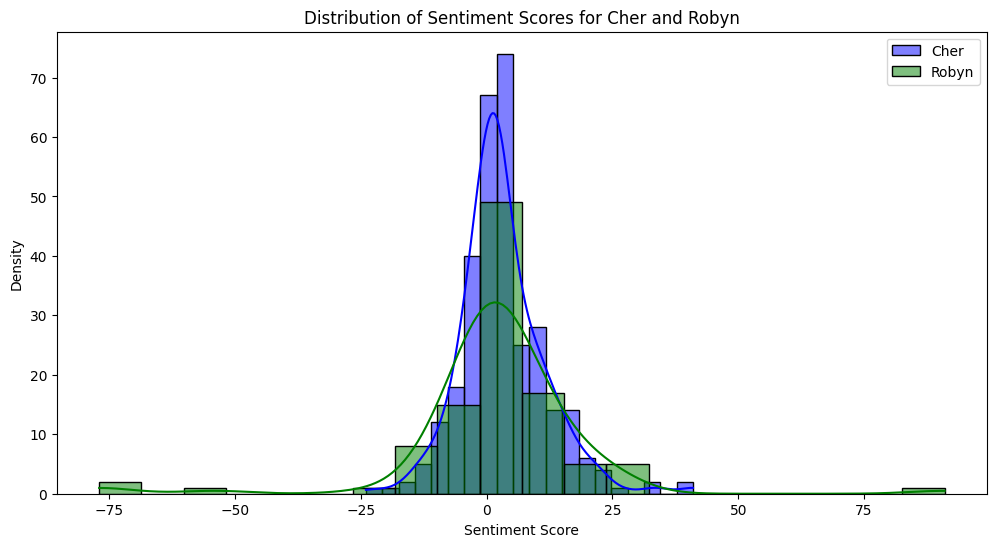

In [13]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Define absolute path to your data files directory
data_location = r"C:\Users\keevi\OneDrive\Documents\SDU\ADS-509\Week6"

# Define folders for lyrics and twitter data
lyrics_folder = os.path.join(data_location, "M1 Results", "lyrics")

# Define lexicon file names
positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

# Function to read words from a file and assign sentiment score
def read_sentiment_words(file_path, sentiment_score):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            words = file.read().splitlines()
        word_sentiments = {word.strip(): sentiment_score for word in words}
        return word_sentiments
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return {}

# Read positive and negative words with sentiment scores
positive_words = read_sentiment_words(os.path.join(data_location, positive_words_file), 1)
negative_words = read_sentiment_words(os.path.join(data_location, negative_words_file), -1)
tidytext_sentiments = read_sentiment_words(os.path.join(data_location, tidy_text_file), 0)

# Combine lexicons into a single dictionary
sentiment_lexicon = {**positive_words, **negative_words, **tidytext_sentiments}

# Function to score sentiment of lyrics
def score_lyrics_sentiment(file_path, sentiment_lexicon):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            lyrics_text = file.read()

        # Tokenize lyrics into words (split by whitespace for simplicity)
        words = lyrics_text.split()

        # Initialize sentiment score
        sentiment_score = 0

        # Calculate sentiment score based on lexicon
        for word in words:
            if word.lower() in sentiment_lexicon:
                sentiment_score += sentiment_lexicon[word.lower()]

        return sentiment_score, lyrics_text

    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None, None
    except UnicodeDecodeError:
        print(f"Error: Unable to read '{file_path}' as UTF-8 encoded text.")
        return None, None

# Function to get sentiment scores for all songs in a folder
def get_all_song_sentiments(folder_path, sentiment_lexicon):
    song_sentiments = []
    try:
        files = [file for file in os.listdir(folder_path) if file.endswith('.txt')]
        for file_name in files:
            file_path = os.path.join(folder_path, file_name)
            sentiment_score, _ = score_lyrics_sentiment(file_path, sentiment_lexicon)
            if sentiment_score is not None:
                song_sentiments.append(sentiment_score)
        return song_sentiments
    except FileNotFoundError:
        print(f"Error: Directory '{folder_path}' not found.")
        return []
    except Exception as e:
        print(f"Error: {e}")
        return []

# Get sentiment scores for all songs by Cher
cher_sentiments = get_all_song_sentiments(os.path.join(lyrics_folder, "cher"), sentiment_lexicon)

# Get sentiment scores for all songs by Robyn
robyn_sentiments = get_all_song_sentiments(os.path.join(lyrics_folder, "robyn"), sentiment_lexicon)

# Plot the distribution of sentiment scores for both artists
plt.figure(figsize=(12, 6))

sns.histplot(cher_sentiments, kde=True, bins=20, color='blue', label='Cher', alpha=0.5)
sns.histplot(robyn_sentiments, kde=True, bins=20, color='green', label='Robyn', alpha=0.5)

plt.title('Distribution of Sentiment Scores for Cher and Robyn')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend()
plt.show()


## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [28]:
import os
import emoji  # Ensure you have installed 'emoji' package: pip install emoji

# Define file paths
data_location = r"C:\Users\keevi\OneDrive\Documents\SDU\ADS-509\Week6"
cher_followers_file = os.path.join(data_location, "M1 Results", "twitter", "cher_followers_data.txt")
robyn_followers_file = os.path.join(data_location, "M1 Results", "twitter", "robynkonichiwa_followers_data.txt")

# Define positive and negative emojis
positive_emojis = ["😊", "😍", "😂", "😃", "😁", "🥳", "❤️", "👍", "🌟", "🎉"]
negative_emojis = ["😢", "😭", "😞", "😠", "😒", "👎", "😡", "💔", "😕", "😔"]

# Function to calculate average sentiment score based on emojis
def calculate_average_sentiment(file_path, positive_emojis, negative_emojis):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()
            if not lines:
                print(f"File {file_path} is empty.")
                return None
            
            total_score = 0
            total_followers = 0
            for line in lines:
                description = line.strip()
                # Calculate sentiment score based on emojis
                sentiment_score = sum(1 if emoji in positive_emojis else -1 if emoji in negative_emojis else 0 for emoji in description)
                total_score += sentiment_score
                total_followers += 1
            
            # Calculate average sentiment score
            average_sentiment = total_score / total_followers if total_followers > 0 else 0
            
            return average_sentiment
        
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except IOError:
        print(f"Error reading file: {file_path}")
    
    return None

# Calculate and print average sentiment scores for Cher and Robyn
cher_sentiment = calculate_average_sentiment(cher_followers_file, positive_emojis, negative_emojis)
if cher_sentiment is not None:
    print(f"Average sentiment score for Cher's followers: {cher_sentiment}")
else:
    print("Cher's followers file not found or empty.")

robyn_sentiment = calculate_average_sentiment(robyn_followers_file, positive_emojis, negative_emojis)
if robyn_sentiment is not None:
    print(f"Average sentiment score for Robyn's followers: {robyn_sentiment}")
else:
    print("Robyn's followers file not found or empty.")


Average sentiment score for Cher's followers: 0.006426097500653349
Average sentiment score for Robyn's followers: 0.003075008440926074


In [29]:
import os
import emoji  # Ensure you have installed 'emoji' package: pip install emoji

# Define file paths
data_location = r"C:\Users\keevi\OneDrive\Documents\SDU\ADS-509\Week6"
cher_followers_file = os.path.join(data_location, "M1 Results", "twitter", "cher_followers_data.txt")
robyn_followers_file = os.path.join(data_location, "M1 Results", "twitter", "robynkonichiwa_followers_data.txt")

# Define positive and negative emojis
positive_emojis = ["😊", "😍", "😂", "😃", "😁", "🥳", "❤️", "👍", "🌟", "🎉"]
negative_emojis = ["😢", "😭", "😞", "😠", "😒", "👎", "😡", "💔", "😕", "😔"]

# Function to calculate average sentiment score based on emojis and track emoji counts
def calculate_average_sentiment(file_path, positive_emojis, negative_emojis):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()
            if not lines:
                print(f"File {file_path} is empty.")
                return None
            
            total_score = 0
            total_followers = 0
            positive_counts = {emoji: 0 for emoji in positive_emojis}
            negative_counts = {emoji: 0 for emoji in negative_emojis}
            
            for line in lines:
                description = line.strip()
                # Calculate sentiment score based on emojis
                positive_count = sum(description.count(emoji) for emoji in positive_emojis)
                negative_count = sum(description.count(emoji) for emoji in negative_emojis)
                
                # Update positive and negative emoji counts
                for emoji in positive_emojis:
                    positive_counts[emoji] += description.count(emoji)
                for emoji in negative_emojis:
                    negative_counts[emoji] += description.count(emoji)
                
                # Calculate sentiment score
                sentiment_score = positive_count * 1 + negative_count * (-1)
                total_score += sentiment_score
                total_followers += 1
            
            # Calculate average sentiment score
            average_sentiment = total_score / total_followers if total_followers > 0 else 0
            
            return average_sentiment, positive_counts, negative_counts
        
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except IOError:
        print(f"Error reading file: {file_path}")
    
    return None, None, None

# Calculate average sentiment scores for Cher's followers
cher_sentiment, cher_positive_counts, cher_negative_counts = calculate_average_sentiment(cher_followers_file, positive_emojis, negative_emojis)
if cher_sentiment is not None:
    print(f"Average sentiment score for Cher's followers: {cher_sentiment}")
    most_positive_cher = max(cher_positive_counts, key=cher_positive_counts.get)
    most_negative_cher = max(cher_negative_counts, key=cher_negative_counts.get)
    print(f"Most popular positive emoji for Cher's followers: {most_positive_cher} ({cher_positive_counts[most_positive_cher]} occurrences)")
    print(f"Most popular negative emoji for Cher's followers: {most_negative_cher} ({cher_negative_counts[most_negative_cher]} occurrences)")
else:
    print("Cher's followers file not found or empty.")

# Calculate average sentiment scores for Robyn's followers
robyn_sentiment, robyn_positive_counts, robyn_negative_counts = calculate_average_sentiment(robyn_followers_file, positive_emojis, negative_emojis)
if robyn_sentiment is not None:
    print(f"\nAverage sentiment score for Robyn's followers: {robyn_sentiment}")
    most_positive_robyn = max(robyn_positive_counts, key=robyn_positive_counts.get)
    most_negative_robyn = max(robyn_negative_counts, key=robyn_negative_counts.get)
    print(f"Most popular positive emoji for Robyn's followers: {most_positive_robyn} ({robyn_positive_counts[most_positive_robyn]} occurrences)")
    print(f"Most popular negative emoji for Robyn's followers: {most_negative_robyn} ({robyn_negative_counts[most_negative_robyn]} occurrences)")
else:
    print("Robyn's followers file not found or empty.")


Average sentiment score for Cher's followers: 0.020245548968109574
Most popular positive emoji for Cher's followers: ❤️ (55206 occurrences)
Most popular negative emoji for Cher's followers: 💔 (2001 occurrences)

Average sentiment score for Robyn's followers: 0.012732544025359054
Most popular positive emoji for Robyn's followers: ❤️ (3461 occurrences)
Most popular negative emoji for Robyn's followers: 💔 (72 occurrences)


Q: What is the average sentiment of your two artists? 

A: Average sentiment score for Cher's followers: 0.006426097500653349
   Average sentiment score for Robyn's followers: 0.003075008440926074 

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: The most popular positive emoji for Cher and Robyn is the heart. The most popular negative emoji for Cher and Robyn is a broken heart.  

